# 06 - Summarization

This is my notebook version of the book chapter from: [Natural Language Processing With Transformers](https://transformersbook.com/).

I use Kaggle now because I am running OOM on my local desktop machine. If you like this topic, just get a copy of the book!

In [1]:
!pip install sacrebleu rouge_score py7zr

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 118.9/118.9 kB 6.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... - done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.4/66.4 kB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 50.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.5/50.5 kB 5.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.6/93.6 kB 10.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 399.2/399.2 kB 35.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 357.2/357.2 kB 28.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 138.6/138.6 kB 13.9 MB/s eta 0:00:00
  Created wheel for rouge_score: filename=rouge_score-0.1.2-py3-none-any.whl size=24955 sha256=d1483ecf4629e1331da59ed0c58ec14979425b746ed1afeb87fcac7a997cb9ed
  Stored in directory: /root/.cache/pip/wheels/8e/6b/70/59daa7c90a238610e34bac5916e001fe3d9bb0ec59c8cf5518
Successfully built rouge_score


## The CNN/DailyMail Dataset

In [2]:
from datasets import load_dataset

In [3]:
dataset = load_dataset("cnn_dailymail", version="3.0.0")
print(f"Features: {dataset['train'].column_names}")

Extracting data files:   0%|          | 0/5 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Dataset cnn_dailymail downloaded and prepared to /root/.cache/huggingface/datasets/cnn_dailymail/default/3.0.0/3cb851bf7cf5826e45d49db2863f627cba583cbc32342df7349dfe6c38060234. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

Features: ['article', 'highlights', 'id']


In [4]:
idx = 1
sample = dataset["train"][idx]
print(f"""
Article (excerpt of 500 characters, total length: {len(sample['article'])}):
""")
print(sample["article"][:500])
print(f"\nSummary (length: {len(sample['highlights'])}):")
print(sample["highlights"])


Article (excerpt of 500 characters, total length: 3192):

(CNN) -- Usain Bolt rounded off the world championships Sunday by claiming his third gold in Moscow as he anchored Jamaica to victory in the men's 4x100m relay. The fastest man in the world charged clear of United States rival Justin Gatlin as the Jamaican quartet of Nesta Carter, Kemar Bailey-Cole, Nickel Ashmeade and Bolt won in 37.36 seconds. The U.S finished second in 37.56 seconds with Canada taking the bronze after Britain were disqualified for a faulty handover. The 26-year-old Bolt has n

Summary (length: 180):
Usain Bolt wins third gold of world championship .
Anchors Jamaica to 4x100m relay victory .
Eighth gold at the championships for Bolt .
Jamaica double up in women's 4x100m relay .


## Text Summarization Pipelines

In [5]:
sample_text = dataset["train"][idx]["article"][:2000]
summaries = {}

In [6]:
import nltk
from nltk.tokenize import sent_tokenize

In [7]:
nltk.download("punkt")

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [8]:
string = "The U.S. are a country. The U.N. is an organization."
sent_tokenize(string)

['The U.S. are a country.', 'The U.N. is an organization.']

### Summarization Baseline

In [9]:
def three_sentence_summary(text):
    return "\n".join(sent_tokenize(text)[:3])

In [10]:
summaries["baseline"] = three_sentence_summary(sample_text)
print(summaries["baseline"])

(CNN) -- Usain Bolt rounded off the world championships Sunday by claiming his third gold in Moscow as he anchored Jamaica to victory in the men's 4x100m relay.
The fastest man in the world charged clear of United States rival Justin Gatlin as the Jamaican quartet of Nesta Carter, Kemar Bailey-Cole, Nickel Ashmeade and Bolt won in 37.36 seconds.
The U.S finished second in 37.56 seconds with Canada taking the bronze after Britain were disqualified for a faulty handover.


### GPT-2

In [11]:
from transformers import pipeline, set_seed

In [12]:
set_seed(42)
pipe = pipeline("text-generation", model="gpt2")
gpt2_query = sample_text + "\nTL;DR:\n"
pipe_out = pipe(gpt2_query, max_length=512, clean_up_tokenization_spaces=True)
summaries["gpt2"] = "\n".join(
    sent_tokenize(pipe_out[0]["generated_text"][len(gpt2_query):])
)
print(summaries["gpt2"])

/opt/conda/lib/python3.7/site-packages/transformers/generation/utils.py:1202: UserWarning: You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed soon, in a future version. Please use a generation configuration file (see https://huggingface.co/docs/transformers/main_classes/text_generation)
  "You have modified the pretrained model configuration to control generation. This is a"
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


"The silver medal gave the men's team a small lead over the Americans.
After a long series of difficult handovers, the Americans managed to hold onto it with their lead-in.
I congratulate them on their new position and hope they can do well."
The Americans were then asked whether they thought to have done what was needed to get on the podium: give the men their medal medals.
With


### T5

In [13]:
pipe = pipeline("summarization", model="t5-base")
pipe_out = pipe(sample_text)
pipe_out

/opt/conda/lib/python3.7/site-packages/transformers/models/t5/tokenization_t5_fast.py:165: FutureWarning: This tokenizer was incorrectly instantiated with a model max length of 512 which will be corrected in Transformers v5.
For now, this behavior is kept to avoid breaking backwards compatibility when padding/encoding with `truncation is True`.
- Be aware that you SHOULD NOT rely on t5-base automatically truncating your input to 512 when padding/encoding.
- If you want to encode/pad to sequences longer than 512 you can either instantiate this tokenizer with `model_max_length` or pass `max_length` when encoding/padding.
- To avoid this warning, please instantiate this tokenizer with `model_max_length` set to your preferred value.
  FutureWarning,


[{'summary_text': 'usain bolt wins third gold medal at world championships . anchors Jamaica to victory in 4x100m relay . anchored by shelly-Ann Fraser-Pryce who completes triple . world champions the united states finish second .'}]

In [14]:
summaries["t5"] = "\n".join(sent_tokenize(pipe_out[0]["summary_text"]))
print(summaries["t5"])

usain bolt wins third gold medal at world championships .
anchors Jamaica to victory in 4x100m relay .
anchored by shelly-Ann Fraser-Pryce who completes triple .
world champions the united states finish second .


### BART

In [15]:
pipe = pipeline("summarization", model="facebook/bart-large-cnn")
pipe_out = pipe(sample_text)
pipe_out

[{'summary_text': "Usain Bolt wins his third gold of the world championships in Moscow. Bolt anchors Jamaica to victory in the men's 4x100m relay. The 26-year-old has now won eight gold medals at world championships. Jamaica's women also win gold in the relay, beating France in the process."}]

In [16]:
summaries["bart"] = "\n".join(sent_tokenize(pipe_out[0]["summary_text"]))
print(summaries["bart"])

Usain Bolt wins his third gold of the world championships in Moscow.
Bolt anchors Jamaica to victory in the men's 4x100m relay.
The 26-year-old has now won eight gold medals at world championships.
Jamaica's women also win gold in the relay, beating France in the process.


### PEGASUS

In [17]:
pipe = pipeline("summarization", model="google/pegasus-cnn_dailymail")
pipe_out = pipe(sample_text)
pipe_out

[{'summary_text': "Usain Bolt wins third gold of world championships .<n>Anchors Jamaica to victory in men's 4x100m relay .<n>Eighth gold at the championships for Bolt .<n>Jamaica also win women's 4x100m relay ."}]

In [18]:
summaries["pegasus"] = pipe_out[0]["summary_text"].replace(" .<n>", ".\n")
print(summaries["pegasus"])

Usain Bolt wins third gold of world championships.
Anchors Jamaica to victory in men's 4x100m relay.
Eighth gold at the championships for Bolt.
Jamaica also win women's 4x100m relay .


## Comparing Different Summaries

In [19]:
print("GROUND TRUTH")
print(dataset["train"][idx]["highlights"])
print("")

for model_name in summaries:
    print(model_name.upper())
    print(summaries[model_name])
    print("")

GROUND TRUTH
Usain Bolt wins third gold of world championship .
Anchors Jamaica to 4x100m relay victory .
Eighth gold at the championships for Bolt .
Jamaica double up in women's 4x100m relay .

BASELINE
(CNN) -- Usain Bolt rounded off the world championships Sunday by claiming his third gold in Moscow as he anchored Jamaica to victory in the men's 4x100m relay.
The fastest man in the world charged clear of United States rival Justin Gatlin as the Jamaican quartet of Nesta Carter, Kemar Bailey-Cole, Nickel Ashmeade and Bolt won in 37.36 seconds.
The U.S finished second in 37.56 seconds with Canada taking the bronze after Britain were disqualified for a faulty handover.

GPT2
"The silver medal gave the men's team a small lead over the Americans.
After a long series of difficult handovers, the Americans managed to hold onto it with their lead-in.
I congratulate them on their new position and hope they can do well."
The Americans were then asked whether they thought to have done what was 

## Measuring the Quality of Generated Text

### BLEU
- https://cloud.google.com/translate/automl/docs/evaluate
- https://towardsdatascience.com/evaluating-text-output-in-nlp-bleu-at-your-own-risk-e8609665a213

In [20]:
from datasets import load_metric

In [21]:
bleu_metric = load_metric("sacrebleu")
bleu_metric

Metric(name: "sacrebleu", features: {'predictions': Value(dtype='string', id='sequence'), 'references': Sequence(feature=Value(dtype='string', id='sequence'), length=-1, id='references')}, usage: """
Produces BLEU scores along with its sufficient statistics
from a source against one or more references.

Args:
    predictions (`list` of `str`): list of translations to score. Each translation should be tokenized into a list of tokens.
    references (`list` of `list` of `str`): A list of lists of references. The contents of the first sub-list are the references for the first prediction, the contents of the second sub-list are for the second prediction, etc. Note that there must be the same number of references for each prediction (i.e. all sub-lists must be of the same length).
    smooth_method (`str`): The smoothing method to use, defaults to `'exp'`. Possible values are:
        - `'none'`: no smoothing
        - `'floor'`: increment zero counts
        - `'add-k'`: increment num/deno

In [22]:
import pandas as pd
import numpy as np

In [23]:
bleu_metric.add(
    prediction="the the the the the the", reference=["the cat is on the mat"]
)
results = bleu_metric.compute(smooth_method="floor", smooth_value=0)
results["precisions"] = [np.round(p, 2) for p in results["precisions"]]
pd.DataFrame.from_dict(results, orient="index", columns=["Value"])

,Value
score,0.0
counts,"[2, 0, 0, 0]"
totals,"[6, 5, 4, 3]"
precisions,"[33.33, 0.0, 0.0, 0.0]"
bp,1.0
sys_len,6
ref_len,6


In [24]:
bleu_metric.add(
    prediction="the cat is on mat", reference=["the cat is on the mat"]
)
results = bleu_metric.compute(smooth_method="floor", smooth_value=0)
results["precisions"] = [np.round(p, 2) for p in results["precisions"]]
pd.DataFrame.from_dict(results, orient="index", columns=["Value"])

,Value
score,57.893007
counts,"[5, 3, 2, 1]"
totals,"[5, 4, 3, 2]"
precisions,"[100.0, 75.0, 66.67, 50.0]"
bp,0.818731
sys_len,5
ref_len,6


### ROGUE
- https://towardsdatascience.com/the-ultimate-performance-metric-in-nlp-111df6c64460

In [25]:
rouge_metric = load_metric("rouge")
rouge_metric

Metric(name: "rouge", features: {'predictions': Value(dtype='string', id='sequence'), 'references': Value(dtype='string', id='sequence')}, usage: """
Calculates average rouge scores for a list of hypotheses and references
Args:
    predictions: list of predictions to score. Each prediction
        should be a string with tokens separated by spaces.
    references: list of reference for each prediction. Each
        reference should be a string with tokens separated by spaces.
    rouge_types: A list of rouge types to calculate.
        Valid names:
        `"rouge{n}"` (e.g. `"rouge1"`, `"rouge2"`) where: {n} is the n-gram based scoring,
        `"rougeL"`: Longest common subsequence based scoring.
        `"rougeLSum"`: rougeLsum splits text using `"
"`.
        See details in https://github.com/huggingface/datasets/issues/617
    use_stemmer: Bool indicating whether Porter stemmer should be used to strip word suffixes.
    use_aggregator: Return aggregates if this is set to True
Retu

In [26]:
rouge_metric.add(prediction="the cat is on mat", reference=["the cat is on the mat"])
rouge_metric.compute()

{'rouge1': AggregateScore(low=Score(precision=1.0, recall=0.8333333333333334, fmeasure=0.9090909090909091), mid=Score(precision=1.0, recall=0.8333333333333334, fmeasure=0.9090909090909091), high=Score(precision=1.0, recall=0.8333333333333334, fmeasure=0.9090909090909091)),
 'rouge2': AggregateScore(low=Score(precision=0.75, recall=0.6, fmeasure=0.6666666666666665), mid=Score(precision=0.75, recall=0.6, fmeasure=0.6666666666666665), high=Score(precision=0.75, recall=0.6, fmeasure=0.6666666666666665)),
 'rougeL': AggregateScore(low=Score(precision=1.0, recall=0.8333333333333334, fmeasure=0.9090909090909091), mid=Score(precision=1.0, recall=0.8333333333333334, fmeasure=0.9090909090909091), high=Score(precision=1.0, recall=0.8333333333333334, fmeasure=0.9090909090909091)),
 'rougeLsum': AggregateScore(low=Score(precision=1.0, recall=0.8333333333333334, fmeasure=0.9090909090909091), mid=Score(precision=1.0, recall=0.8333333333333334, fmeasure=0.9090909090909091), high=Score(precision=1.0, r

In [27]:
reference = dataset["train"][idx]["highlights"]
records = []
rouge_names = ["rouge1", "rouge2", "rougeL", "rougeLsum"]

In [28]:
for model_name in summaries:
    rouge_metric.add(prediction=summaries[model_name], reference=reference)
    score = rouge_metric.compute()
    rouge_dict = dict((rn, score[rn].mid.fmeasure) for rn in rouge_names)
    records.append(rouge_dict)
pd.DataFrame.from_records(records, index=summaries.keys())

,rouge1,rouge2,rougeL,rougeLsum
baseline,0.303571,0.090909,0.214286,0.232143
gpt2,0.100000,0.000000,0.060000,0.100000
t5,0.524590,0.237288,0.426230,0.491803
bart,0.582278,0.207792,0.455696,0.506329
pegasus,0.866667,0.655172,0.800000,0.833333


## Evaluating PEGASUS on the CNN/DailyMail Dataset

In [29]:
def evaluate_summaries_baseline(
    dataset, metric, column_text="article", column_summary="highlights"
):
    summaries = [three_sentence_summary(text) for text in dataset[column_text]]
    metric.add_batch(predictions=summaries, references=dataset[column_summary])
    score = metric.compute()
    return score

In [30]:
text_sampled = dataset["test"].shuffle(seed=42).select(range(1000))

In [31]:
score = evaluate_summaries_baseline(text_sampled, rouge_metric)
rouge_dict = dict((rn, score[rn].mid.fmeasure) for rn in rouge_names)
pd.DataFrame.from_dict(rouge_dict, orient="index", columns=["baseline"]).T

,rouge1,rouge2,rougeL,rougeLsum
baseline,0.388071,0.170554,0.247146,0.354972


In [32]:
from tqdm import tqdm
import torch

In [33]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [34]:
def chunks(list_of_elements, batch_size):
    """Yield successive batch-sized chunks from list_of_elements."""
    for i in range(0, len(list_of_elements), batch_size):
        yield list_of_elements[i : i + batch_size]

In [35]:
def evaluate_summaries_pegasus(
    dataset,
    metric,
    model,
    tokenizer,
    batch_size=16,
    device=device,
    column_text="article",
    column_summary="highlights",
):
    article_batches = list(chunks(dataset[column_text], batch_size))
    summaries_batches = list(chunks(dataset[column_summary], batch_size))

    for article_batch, target_batch in tqdm(
        zip(article_batches, summaries_batches), total=len(article_batches)
    ):
        inputs = tokenizer(
            article_batch,
            max_length=1024,
            truncation=True,
            padding="max_length",
            return_tensors="pt",
        )
        summaries = model.generate(
            inputs=inputs["input_ids"].to(device),
            attention_mask=inputs["attention_mask"].to(device),
            length_penalty=0.8,
            num_beams=8,
            max_length=128,
        )
        decoded_summaries = [
            tokenizer.decode(
                s, skip_special_tokens=True, clean_up_tokenization_spaces=True
            )
            for s in summaries
        ]
        decoded_summaries = [d.replace("\n", " ") for d in decoded_summaries]
        metric.add_batch(predictions=decoded_summaries, references=target_batch)
    score = metric.compute()
    return score


In [36]:
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer

In [37]:
model_ckpt = "google/pegasus-cnn_dailymail"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
model = AutoModelForSeq2SeqLM.from_pretrained(model_ckpt).to(device)

In [38]:
i = 1
article, summary_solution = dataset["test"][i]["article"], dataset["test"][i]["highlights"]
print(article)
t = tokenizer(dataset["test"][1]["article"], return_tensors="pt")
print(t)
t = model.generate(t["input_ids"].to(device))
print(t)
summary = tokenizer.decode(t[0], clean_up_tokenization_spaces=True, skip_special_tokens=True)
print(summary)
print(summary_solution)

(CNN)The attorney for a suburban New York cardiologist charged in what authorities say was a failed scheme to have another physician hurt or killed is calling the allegations against his client "completely unsubstantiated." Appearing Saturday morning on CNN's "New Day," Randy Zelin defended his client, Dr. Anthony Moschetto, who faces criminal solicitation, conspiracy, burglary, arson, criminal prescription sale and weapons charges in connection to what prosecutors called a plot to take out a rival doctor on Long Island. "None of anything in this case has any evidentiary value," Zelin told CNN's Christi Paul.  "It doesn't matter what anyone says, he is presumed to be innocent." Moschetto,54, pleaded not guilty to all charges Wednesday.  He was released after posting $2 million bond and surrendering his passport. Zelin said that his next move is to get Dr. Moshetto back to work. "He's got patients to see. This man, while he was in a detention cell, the only thing that he cared about wer

/opt/conda/lib/python3.7/site-packages/transformers/generation/utils.py:1292: UserWarning: Using `max_length`'s default (128) to control the generation length. This behaviour is deprecated and will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  UserWarning,


tensor([[    0,   982,   107,  6786, 23978, 31810,   497,   117,  3131,   115,
           180,  3740,   416,   140,   114,  3004,  4715,   112,   133,   372,
          5786,  4005,   132,  3040,   110,   107,   106,   194, 22806,   113,
           742,   115,   136,   437,   148,   189, 87547,   564,   745,   169,
          3022,   649,   110,   107,     1]], device='cuda:0')
Dr. Anthony Moschetto is charged in what authorities say was a failed plot to have another physician hurt or killed.<n>"None of anything in this case has any evidentiary value," his attorney says.
A lawyer for Dr. Anthony Moschetto says the charges against him are baseless .
Moschetto, 54, was arrested for selling drugs and weapons, prosecutors say .
Authorities allege Moschetto hired accomplices to burn down the practice of former associate .


In [39]:
score = evaluate_summaries_pegasus(text_sampled, rouge_metric, model, tokenizer, batch_size=8)

100%|██████████| 125/125 [16:28<00:00,  7.91s/it]


In [40]:
rouge_dict = dict((rn, score[rn].mid.fmeasure) for rn in rouge_names)
pd.DataFrame(rouge_dict, index=["pegasus"])

,rouge1,rouge2,rougeL,rougeLsum
pegasus,0.417083,0.200608,0.297936,0.360728


## Training a Summarization Model

In [41]:
dataset_samsum = load_dataset("samsum")
split_lenghts = [len(dataset_samsum[split]) for split in dataset_samsum]

Generating train split:   0%|          | 0/14732 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/819 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/818 [00:00<?, ? examples/s]

Dataset samsum downloaded and prepared to /root/.cache/huggingface/datasets/samsum/samsum/0.0.0/3f7dba43be72ab10ca66a2e0f8547b3590e96c2bd9f2cbb1f6bb1ec1f1488ba6. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

In [42]:
print(f"Split lengths: {split_lenghts}")
print(f"Features: {dataset_samsum['train'].column_names}")
print("\nDialogue:")
print(dataset_samsum["test"][0]["dialogue"])
print("\nSummary:")
print(dataset_samsum["test"][0]["summary"])

Split lengths: [14732, 819, 818]
Features: ['id', 'dialogue', 'summary']

Dialogue:
Hannah: Hey, do you have Betty's number?
Amanda: Lemme check
Hannah: <file_gif>
Amanda: Sorry, can't find it.
Amanda: Ask Larry
Amanda: He called her last time we were at the park together
Hannah: I don't know him well
Hannah: <file_gif>
Amanda: Don't be shy, he's very nice
Hannah: If you say so..
Hannah: I'd rather you texted him
Amanda: Just text him 🙂
Hannah: Urgh.. Alright
Hannah: Bye
Amanda: Bye bye

Summary:
Hannah needs Betty's number but Amanda doesn't have it. She needs to contact Larry.


### Evaluating PEGASUS on SAMSum

In [43]:
pipe_out = pipe(dataset_samsum["test"][0]["dialogue"])
pipe_out

Your max_length is set to 128, but you input_length is only 122. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=61)


[{'summary_text': "Amanda: Ask Larry Amanda: He called her last time we were at the park together .<n>Hannah: I'd rather you texted him .<n>Amanda: Just text him ."}]

In [44]:
print("Summary:")
print(pipe_out[0]["summary_text"].replace(".<n>", ".\n"))

Summary:
Amanda: Ask Larry Amanda: He called her last time we were at the park together .
Hannah: I'd rather you texted him .
Amanda: Just text him .


In [45]:
score = evaluate_summaries_pegasus(
    dataset_samsum["test"], rouge_metric, model, tokenizer, column_text="dialogue", column_summary="summary", batch_size=8
)

100%|██████████| 103/103 [12:30<00:00,  7.29s/it]


In [46]:
rouge_dict = dict((rn, score[rn].mid.fmeasure) for rn in rouge_names)
pd.DataFrame(rouge_dict, index=["pegasus"])

,rouge1,rouge2,rougeL,rougeLsum
pegasus,0.285445,0.083233,0.221051,0.221393


### Fine-Tuning PEGASUS

In [47]:
import matplotlib.pyplot as plt

In [48]:
d_len = [len(tokenizer.encode(s)) for s in dataset_samsum["train"]["dialogue"]]
s_len = [len(tokenizer.encode(s)) for s in dataset_samsum["train"]["summary"]]

Token indices sequence length is longer than the specified maximum sequence length for this model (1044 > 1024). Running this sequence through the model will result in indexing errors


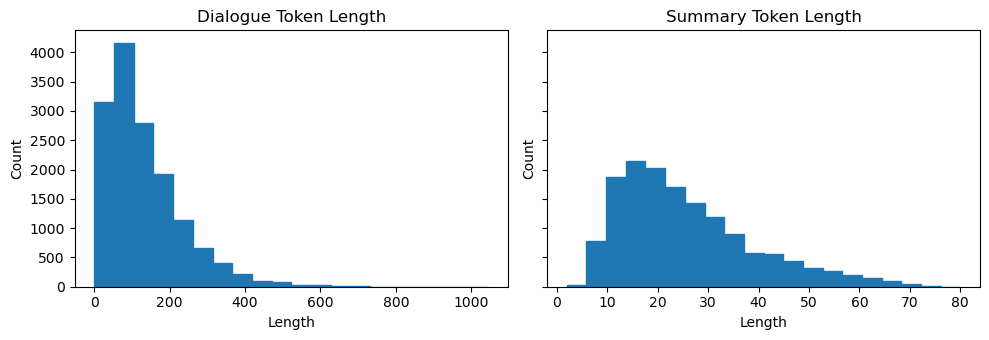

In [49]:
fig, axes = plt.subplots(1, 2, figsize=(10, 3.5), sharey=True)
axes[0].hist(d_len, bins=20, color="C0", edgecolor="C0")
axes[0].set_title("Dialogue Token Length")
axes[0].set_xlabel("Length")
axes[0].set_ylabel("Count")
axes[1].hist(s_len, bins=20, color="C0", edgecolor="C0")
axes[1].set_title("Summary Token Length")
axes[1].set_xlabel("Length")
axes[1].set_ylabel("Count")
plt.tight_layout()
plt.show()

In [50]:
def convert_examples_to_features(example_batch):
    input_encodings = tokenizer(example_batch["dialogue"], max_length=1024, truncation=True)
    with tokenizer.as_target_tokenizer():
        target_encodings = tokenizer(example_batch["summary"], max_length=128, truncation=True)
    return {
        "input_ids": input_encodings["input_ids"],
        "attention_mask": input_encodings["attention_mask"],
        "labels": target_encodings["input_ids"]
    }

In [51]:
dataset_samsum_pt = dataset_samsum.map(convert_examples_to_features, batched=True)
columns = ["input_ids", "labels", "attention_mask"]
dataset_samsum_pt.set_format(type="torch", columns=columns)
dataset_samsum_pt

  0%|          | 0/15 [00:00<?, ?ba/s]

/opt/conda/lib/python3.7/site-packages/transformers/tokenization_utils_base.py:3587: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  "`as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your "


  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

DatasetDict({
    train: Dataset({
        features: ['id', 'dialogue', 'summary', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 14732
    })
    test: Dataset({
        features: ['id', 'dialogue', 'summary', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 819
    })
    validation: Dataset({
        features: ['id', 'dialogue', 'summary', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 818
    })
})

In [52]:
from transformers import DataCollatorForSeq2Seq

In [53]:
seq2seq_data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)

In [54]:
from transformers import TrainingArguments, Trainer

In [55]:
training_args = TrainingArguments(
    output_dir="pegasus-samsum",
    num_train_epochs=1,
    warmup_steps=500,
    per_device_train_batch_size=1,
    per_device_eval_batch_size=1,
    weight_decay=0.01,
    logging_steps=10,
    push_to_hub=False,
    evaluation_strategy="epoch",
    eval_steps=500,
    save_steps=1e6,
    gradient_accumulation_steps=16,
    report_to=[],
)
training_args

TrainingArguments(
_n_gpu=1,
adafactor=False,
adam_beta1=0.9,
adam_beta2=0.999,
adam_epsilon=1e-08,
auto_find_batch_size=False,
bf16=False,
bf16_full_eval=False,
data_seed=None,
dataloader_drop_last=False,
dataloader_num_workers=0,
dataloader_pin_memory=True,
ddp_bucket_cap_mb=None,
ddp_find_unused_parameters=None,
ddp_timeout=1800,
debug=[],
deepspeed=None,
disable_tqdm=False,
do_eval=True,
do_predict=False,
do_train=False,
eval_accumulation_steps=None,
eval_delay=0,
eval_steps=500,
evaluation_strategy=epoch,
fp16=False,
fp16_backend=auto,
fp16_full_eval=False,
fp16_opt_level=O1,
fsdp=[],
fsdp_config={'fsdp_min_num_params': 0, 'xla': False, 'xla_fsdp_grad_ckpt': False},
fsdp_min_num_params=0,
fsdp_transformer_layer_cls_to_wrap=None,
full_determinism=False,
gradient_accumulation_steps=16,
gradient_checkpointing=False,
greater_is_better=None,
group_by_length=False,
half_precision_backend=auto,
hub_model_id=None,
hub_private_repo=False,
hub_strategy=every_save,
hub_token=<HUB_TOKEN>,
ign

In [56]:
trainer = Trainer(
    model=model, 
    args=training_args, 
    tokenizer=tokenizer, 
    data_collator=seq2seq_data_collator,
    train_dataset=dataset_samsum_pt["train"],
    eval_dataset=dataset_samsum_pt["validation"],
)
trainer

In [57]:
trainer.train()

/opt/conda/lib/python3.7/site-packages/transformers/optimization.py:395: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
You're using a PegasusTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss
0,1.581300,1.424099


TrainOutput(global_step=920, training_loss=1.8213829185651695, metrics={'train_runtime': 2021.1154, 'train_samples_per_second': 7.289, 'train_steps_per_second': 0.455, 'total_flos': 5526961323663360.0, 'train_loss': 1.8213829185651695, 'epoch': 1.0})

In [58]:
score = evaluate_summaries_pegasus(
    dataset_samsum["test"],
    rouge_metric,
    trainer.model,
    tokenizer,
    batch_size=2,
    column_text="dialogue",
    column_summary="summary",
)
rouge_dict = dict((rn, score[rn].mid.fmeasure) for rn in rouge_names)
pd.DataFrame(rouge_dict, index=["pegasus"])

100%|██████████| 410/410 [08:24<00:00,  1.23s/it]


,rouge1,rouge2,rougeL,rougeLsum
pegasus,0.441746,0.210189,0.349064,0.349013


### Generating Dialogue Summaries

In [59]:
gen_kwargs = {"length_penalty": 0.8, "num_beams": 8, "max_length": 128}
sample_text = dataset_samsum["test"][0]["dialogue"]
reference = dataset_samsum["test"][0]["summary"]
pipe = pipeline("summarization", model="transformersbook/pegasus-samsum")

In [60]:
print("Dialogue:")
print(sample_text)
print("\nReference Summary:")
print(reference)
print("\nModel Summary:")
print(pipe(sample_text, **gen_kwargs)[0]["summary_text"])

Your max_length is set to 128, but you input_length is only 122. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=61)


Dialogue:
Hannah: Hey, do you have Betty's number?
Amanda: Lemme check
Hannah: <file_gif>
Amanda: Sorry, can't find it.
Amanda: Ask Larry
Amanda: He called her last time we were at the park together
Hannah: I don't know him well
Hannah: <file_gif>
Amanda: Don't be shy, he's very nice
Hannah: If you say so..
Hannah: I'd rather you texted him
Amanda: Just text him 🙂
Hannah: Urgh.. Alright
Hannah: Bye
Amanda: Bye bye

Reference Summary:
Hannah needs Betty's number but Amanda doesn't have it. She needs to contact Larry.

Model Summary:
Amanda can't find Betty's number. Larry called Betty last time they were at the park together. Hannah wants Amanda to text Larry instead of calling Betty.


In [61]:
custom_dialogue = """\
Thom: Hi guys, have you heard of transformers?
Lewis: Yes, I used them recently!
Leandro: Indeed, there is a great library by Hugging Face.
Thom: I know, I helped build it ;)
Lewis: Cool, maybe we should write a book about it. What do you think?
Leandro: Great idea, how hard can it be?!
Thom: I am in!
Lewis: Awesome, let's do it together!
"""
print(pipe(custom_dialogue, **gen_kwargs)[0]["summary_text"])

Your max_length is set to 128, but you input_length is only 91. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=45)


Thom, Lewis and Leandro are going to write a book about transformers. Thom helped build a library by Hugging Face. They are going to do it together.
